In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
# plt.style.use('rose-pine-dawn')

from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
#     parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [13]:
data = pd.read_csv('HD142527A_ATV.csv')
data = data[data.index != 2]
data = data[data.index != 6]
data[np.isnan(data)==True] = 0
data['Star ratio'] = data['Line Counts']/data['Cont Counts']
data = data[0:6]
data

,Epoch,Line Counts,Cont Counts,Scale,Exposure (sec),Line Ghost Counts,Cont Ghost Counts,"Line BKA (scaled to input psf, so this is already in ""ghost"" units)",Line BKA err,Companion Cont Alpha,Cont Alpha err,Star ratio
0,56393,282080.0,3.267880e+05,0.9,2.27,1554.5,1719.59,49.71,7.16,28.88,6.15,0.863190
1,56755,568561.0,5.064620e+05,1.2,2.27,2995.0,2507.01,31.77,6.09,25.78,9.40,1.122613
3,57157,488362.0,4.290620e+05,1.2,2.27,2628.0,2161.73,57.22,9.48,27.11,9.70,1.138208
4,57158,1027017.0,9.287127e+05,1.2,2.27,5773.0,4730.93,39.06,10.40,35.30,11.41,1.105850
5,57160,16683996.0,1.013874e+07,1.8,30.00,93783.0,51647.50,50.40,9.26,35.82,7.71,1.645568
7,58235,969732.9,8.096610e+05,1.3,5.00,5451.0,4124.40,52.24,15.92,25.15,13.00,1.197702


In [14]:
from astropy.time import Time
data['year'] = Time(data['Epoch'], format='mjd').decimalyear

In [15]:
x = data['year']

# alpha * initial guess / ghost-to-star-ratio = contrast
ha_g_t_s = 185.25#data['Cont Counts']/data['Line Ghost Counts']
ha_g_t_s_err = 14.58
cont_g_t_s = 196.31#data['Cont Counts']/data['Cont Ghost Counts']
cont_g_t_s_err = 36.06

pflux_ha = data['Line BKA (scaled to input psf, so this is already in "ghost" units)']*1e-2/data['Star ratio']
pflux_cont = data['Companion Cont Alpha']*1e-2
contrast_ha = pflux_ha/ha_g_t_s
contrast_cont = pflux_cont/cont_g_t_s

# ERROR PROPAG TIME
pflux_ha_err = data['Line BKA err']*1e-2/data['Star ratio']
contrast_ha_err = np.sqrt(((pflux_ha_err/pflux_ha)**2)+((ha_g_t_s_err/ha_g_t_s)**2))*contrast_ha
pflux_cont_err = data['Cont Alpha err']*1e-2
contrast_cont_err = np.sqrt(((pflux_cont_err/pflux_cont)**2)+((cont_g_t_s_err/cont_g_t_s)**2))*contrast_cont

<ipython-input-16-caed8e2318c7>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set(xticklabels=['5/15','5/16','5/18'], xticks=[2015.367123, 2015.369863, 2015.375342])


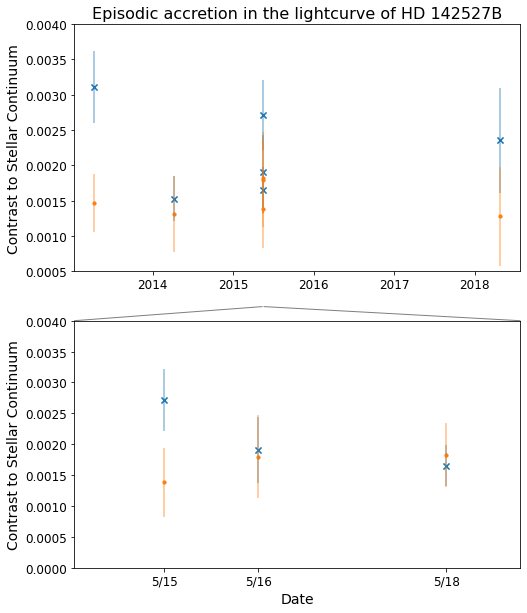

In [16]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,10))
ax1.errorbar(x, contrast_ha, yerr=contrast_ha_err, ls='none', marker='x', alpha=0.5)
ax1.scatter(x, contrast_ha, marker='x')
ax1.errorbar(x, contrast_cont, yerr=contrast_cont_err, ls='none', marker='.', alpha=0.5)
ax1.scatter(x, contrast_cont, marker='.')
ax1.set_ylim(0.0005, 0.004)
ax1.set_title('Episodic accretion in the lightcurve of HD 142527B')
plt.xlabel('Date')
ax1.set_ylabel('Contrast to Stellar Continuum')
ax2.set_ylabel('Contrast to Stellar Continuum')


ax2.errorbar(x, contrast_ha, yerr=contrast_ha_err, ls='none', marker='x', alpha=0.5)
ax2.scatter(x, contrast_ha, marker='x')
ax2.errorbar(x, contrast_cont, yerr=contrast_cont_err, ls='none', marker='.', alpha=0.5)
ax2.set_ylim(0.0,0.004)
ax2.scatter(x, contrast_cont, marker='.')
ax2.set_xlim(2015.3645, 2015.3775)
ax2.set(xticklabels=['5/15','5/16','5/18'], xticks=[2015.367123, 2015.369863, 2015.375342])

mark_inset(ax1, ax2, loc1a=1, loc1b=4, loc2a=2, loc2b=3, fc="none", ec="0.5", zorder=0)

# mark_inset(ax1,ax2,loc1=1,loc2=2,fc="none",ec='0.5')
plt.savefig('hd142527B_contrast_lc.png', dpi=300)

In [18]:
# Close et al 2014

C14epoch = Time(56393, format='mjd').decimalyear
C14_hamag = 6.33
C14_hamag_err = 0.20
C14_contmag = 7.5
C14_contmag_err = 0.25

# Cugno et al 2019
import datetime 
Cu19yr = datetime.datetime(2016,3,31)
Cu19epoch = Time(Cu19yr, format='datetime').decimalyear
Cu19_hamag = 6.7
Cu19_hamag_err = 0.2
Cu19_contmag = 7.3
Cu19_contmag_err = 0.3


In [28]:
# SAME BUT IN MAG

mag_ha = -2.5*np.log10(contrast_ha)
mag_cont = -2.5*np.log10(contrast_cont)

# ERROR PROPAG TIME

mag_ha_err = 2.5*0.434*(contrast_ha_err/contrast_ha)
mag_cont_err = 2.5*0.434*(contrast_cont_err/contrast_cont)

<ipython-input-29-e45c5b6bb869>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set(xticklabels=['5/15','5/16','5/18'], xticks=[2015.367123, 2015.369863, 2015.375342])


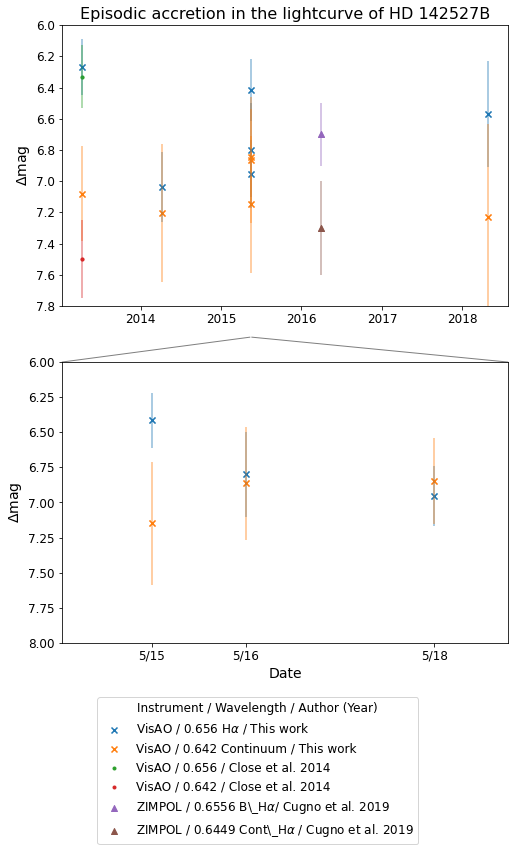

In [29]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,13))

# plot my mags
# fig, ax1 = plt.subplots(figsize=(10,5))
ax1.errorbar(x, mag_ha, yerr=mag_ha_err, ls='none', marker='x', alpha=0.5)
ax1.scatter(x, mag_ha, marker='x', label=r'VisAO / 0.656 H$\alpha$ / This work')
ax1.errorbar(x, mag_cont, yerr=mag_cont_err, ls='none', marker='x', alpha=0.5)
ax1.scatter(x, mag_cont, marker='x', label=r'VisAO / 0.642 Continuum / This work')
ax1.set_ylim(7.8,6)
ax1.set_title('Episodic accretion in the lightcurve of HD 142527B')
ax2.set_xlabel('Date')
ax1.set_ylabel(r'$\Delta$mag')
ax2.set_ylabel(r'$\Delta$mag')

# plot close 2014
ax1.scatter(C14epoch, C14_hamag, marker='.', label=r'VisAO / 0.656 / Close et al. 2014')
ax1.errorbar(C14epoch, C14_hamag, yerr=C14_hamag_err, ls='none', marker='.', alpha=0.5)
ax1.scatter(C14epoch, C14_contmag, marker='.', label='VisAO / 0.642 / Close et al. 2014')
ax1.errorbar(C14epoch, C14_contmag, yerr=C14_contmag_err, ls='none', marker='.', alpha=0.5)
# plot cugno 2019
ax1.scatter(Cu19epoch, Cu19_hamag, marker='^', label=r'ZIMPOL / 0.6556 B\_H$\alpha$/ Cugno et al. 2019')
ax1.errorbar(Cu19epoch, Cu19_hamag, yerr=Cu19_hamag_err, ls='none', marker='^', alpha=0.5)
ax1.scatter(Cu19epoch, Cu19_contmag, marker='^', label=r'ZIMPOL / 0.6449 Cont\_H$\alpha$ / Cugno et al. 2019')
ax1.errorbar(Cu19epoch, Cu19_contmag, yerr=Cu19_contmag_err, ls='none', marker='^', alpha=0.5)
# zoom in on May 2015
ax2.errorbar(x, mag_ha, yerr=mag_ha_err, ls='none', marker='x', alpha=0.5)
ax2.scatter(x, mag_ha, marker='x')
ax2.errorbar(x, mag_cont, yerr=mag_cont_err, ls='none', marker='x', alpha=0.5)
ax2.scatter(x, mag_cont, marker='x')
ax2.set_ylim(8,6)
ax2.set_xlim(2015.3645, 2015.3775)
ax2.set(xticklabels=['5/15','5/16','5/18'], xticks=[2015.367123, 2015.369863, 2015.375342])
mark_inset(ax1, ax2, loc1a=1, loc1b=1, loc2a=2, loc2b=2, fc="none", ec="0.5", zorder=0)



fig.subplots_adjust(bottom=0.22, wspace=0.33)

fig.legend(loc='lower center', borderaxespad=0.5,    # Small spacing around legend box
           title="Instrument / Wavelength / Author (Year)"  # Title for the legend
           )

# ax[1].legend(handles = [l1,l2,l3] , labels=['A', 'B', 'C'],loc='upper center', 
#              bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3)

plt.savefig('hd142527B_contrast_lc_mag.png', dpi=300)

In [30]:
contrasts = pd.DataFrame()
contrasts['yr'] = x
contrasts['DmagHa'] = contrast_ha
contrasts['DmagCont'] = contrast_cont
contrasts.to_csv('HD142527B_contrasts.csv')

In [31]:
contrasts

,yr,DmagHa,DmagCont
0,2013.273973,0.003109,0.001471
1,2014.265753,0.001528,0.001313
3,2015.367123,0.002714,0.001381
4,2015.369863,0.001907,0.001798
5,2015.375342,0.001653,0.001825
7,2018.317808,0.002354,0.001281
